In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / 'batch' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
df_imgs

,Condition,FOV,Path
0,100nM,P10,Y:\coskun-lab\Thomas\23_PLA_revision\data\batc...
1,100nM,P21,Y:\coskun-lab\Thomas\23_PLA_revision\data\batc...
2,Control,P10,Y:\coskun-lab\Thomas\23_PLA_revision\data\batc...
3,Control,P21,Y:\coskun-lab\Thomas\23_PLA_revision\data\batc...


# PLA quantification

In [6]:
import PLA

PPI_save_path =  data_dir / 'batch' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [7]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)


['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']
['DNA' 'Sox2/Oct4' 'p-P90rsk/NF-Kb' 'DNA' 'Cyclin D1/CDK4' 'Bim/Tom20'
 'DNA' 'Concanavalin A' 'Phalloidin' 'WGA']


In [8]:
df_imgs['FOV'] = df_imgs['FOV'].astype(str)

In [9]:
RNAs = ['Sox2/Oct4', 'p-P90rsk/NF-Kb', 'Cyclin D1/CDK4', 'Bim/Tom20']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path)
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    for RNA in RNAs: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.05)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
        
    # Save PPI dict
    name = '_'.join(row[1:3])+'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)
    

Reading image Sox2/Oct4
Processing image Sox2/Oct4
(array([0, 1], dtype=uint8), array([14351011,  1683845], dtype=int64))
Reading image p-P90rsk/NF-Kb
Processing image p-P90rsk/NF-Kb


KeyboardInterrupt: 

In [ ]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(img))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

# QC segmentation

In [ ]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [ ]:
# Read masks paths 
mask_dir = data_dir /  'batch' / 'imgs' / 'masks'
mask_filt_dir = data_dir /  'batch' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [ ]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

# Extract per cell PPI count

In [ ]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [ ]:
mask_filt_dir = data_dir /'batch'  / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / 'batch'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [ ]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# PPI quantification

In [6]:
PPI_save_path =  data_dir / 'batch' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [7]:
df.head()

,Cyto,x,y,PPI,Nuclei,Condition,FOV
0,0,2445,3266,Sox2/Oct4,0,100nM,P10
1,0,2445,3266,Sox2/Oct4,0,100nM,P10
2,0,2445,3266,Sox2/Oct4,0,100nM,P10
3,0,2445,3266,Sox2/Oct4,0,100nM,P10
4,313,3363,1184,Sox2/Oct4,0,100nM,P10


In [8]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

In [9]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']


In [10]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [11]:
df_all.Count_cell.describe()

count    4236.000000
mean       10.051700
std        13.898635
min         0.000000
25%         2.000000
50%         6.000000
75%        13.000000
max       207.000000
Name: Count_cell, dtype: float64

In [12]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 100

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

C:\Users\thu71\AppData\Local\Temp\ipykernel_1047428\489516438.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,1049.000000,1049.0,1049.000000
mean,38.517636,0.0,38.517636
std,25.182766,0.0,25.182766
min,1.000000,0.0,1.000000
25%,21.000000,0.0,21.000000
50%,32.000000,0.0,32.000000
75%,51.000000,0.0,51.000000
max,162.000000,0.0,162.000000


In [13]:
df_all = df_all[df_all['Count_cyto']>=0]


In [14]:
df_all['Condition'] = df_all['Condition'] + '_' +  df_all['FOV']

In [15]:
df_all.Condition.unique()

array(['100nM_P10', '100nM_P21', 'Control_P10', 'Control_P21'],
      dtype=object)

In [16]:
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

## PLOT

In [26]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(8,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.2):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='full', loc='outside', verbose=2, show_test_name=False)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Cyclin D1/CDK4_100nM_P10 vs. Cyclin D1/CDK4_Control_P10: Mann-Whitney-Wilcoxon test two-sided, P_val:8.692e-03 U_stat=6.268e+04
Bim/Tom20_100nM_P10 vs. Bim/Tom20_Control_P10: Mann-Whitney-Wilcoxon test two-sided, P_val:5.930e-02 U_stat=6.069e+04
Sox2/Oct4_100nM_P10 vs. Sox2/Oct4_Control_P10: Mann-Whitney-Wilcoxon test two-sided, P_val:1.925e-04 U_stat=6.550e+04
p-P90rsk/NF-Kb_100nM_P10 vs. p-P90rsk/NF-Kb_Control_P10: Mann-Whitney-Wilcoxon test two-sided, P_val:1.595e-02 U_stat=6.211e+04


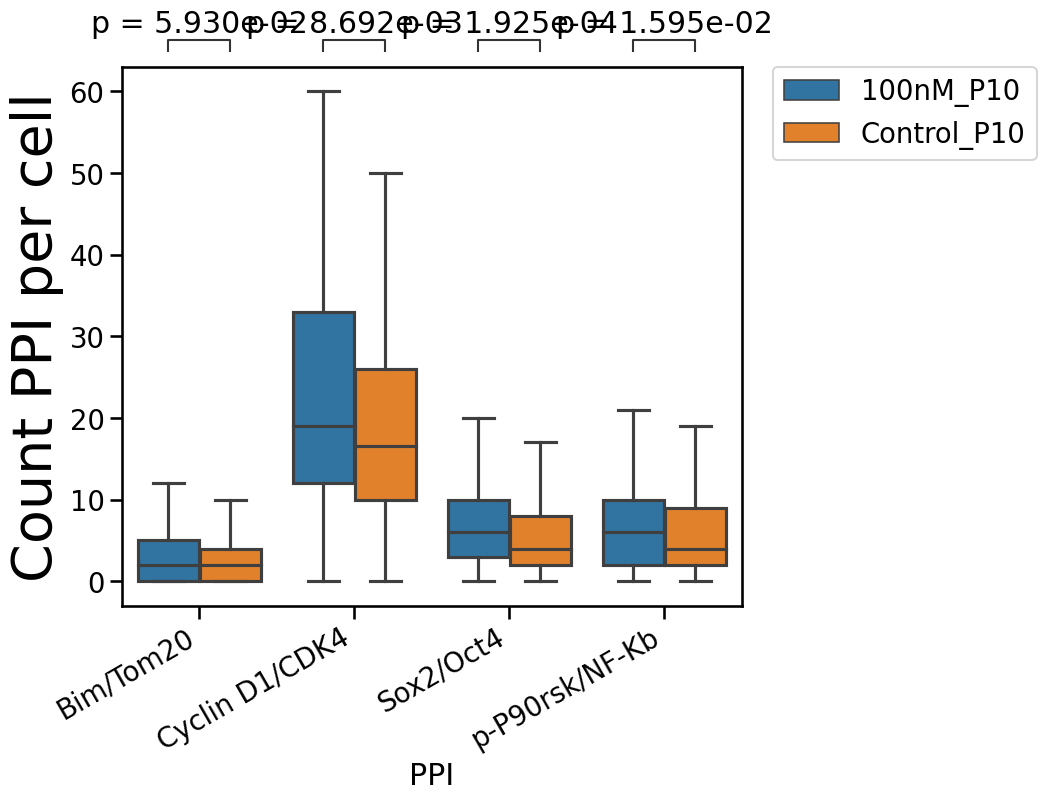

In [27]:
# Boxplot per cell
plotting = {
    "data": df_all[df_all.FOV == 'P10'],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin D1/CDK4_100nM_P21 vs. Cyclin D1/CDK4_Control_P21: Mann-Whitney-Wilcoxon test two-sided, P_val:1.891e-04 U_stat=1.722e+04
Bim/Tom20_100nM_P21 vs. Bim/Tom20_Control_P21: Mann-Whitney-Wilcoxon test two-sided, P_val:1.228e-02 U_stat=1.610e+04
Sox2/Oct4_100nM_P21 vs. Sox2/Oct4_Control_P21: Mann-Whitney-Wilcoxon test two-sided, P_val:1.538e-01 U_stat=1.519e+04
p-P90rsk/NF-Kb_100nM_P21 vs. p-P90rsk/NF-Kb_Control_P21: Mann-Whitney-Wilcoxon test two-sided, P_val:4.105e-01 U_stat=1.466e+04


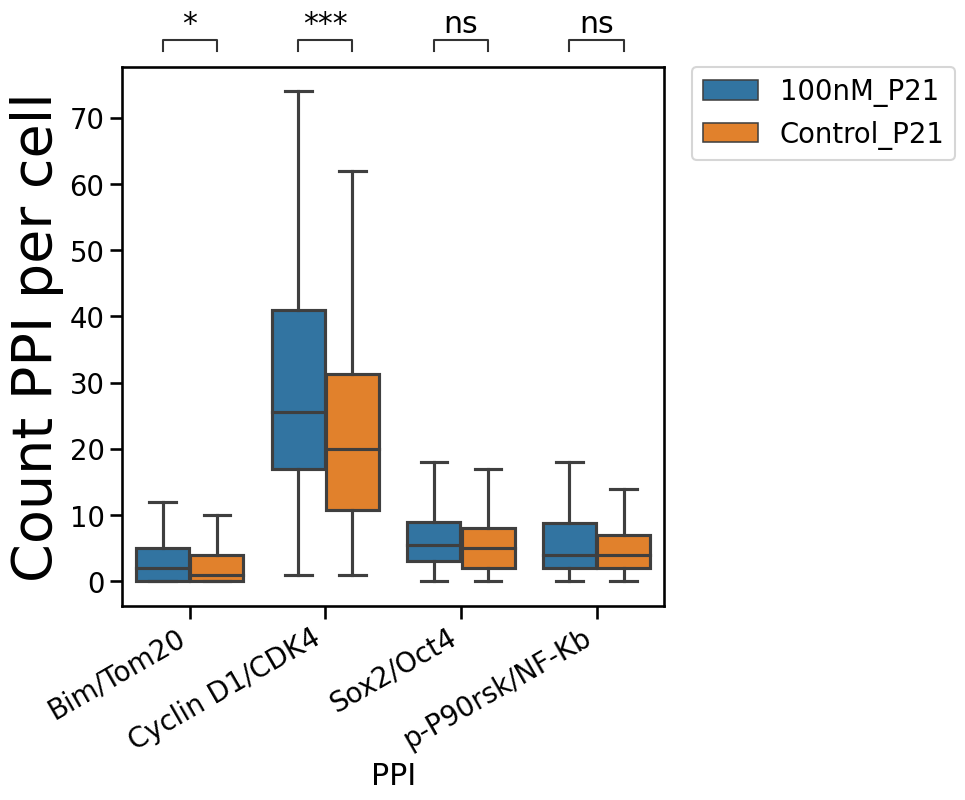

In [24]:
# Boxplot per cell
plotting = {
    "data": df_all[df_all.FOV == 'P21'],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

In [36]:
df_all.Condition.unique()

array(['100nM_P10', '100nM_P21', 'Control_P10', 'Control_P21'],
      dtype=object)

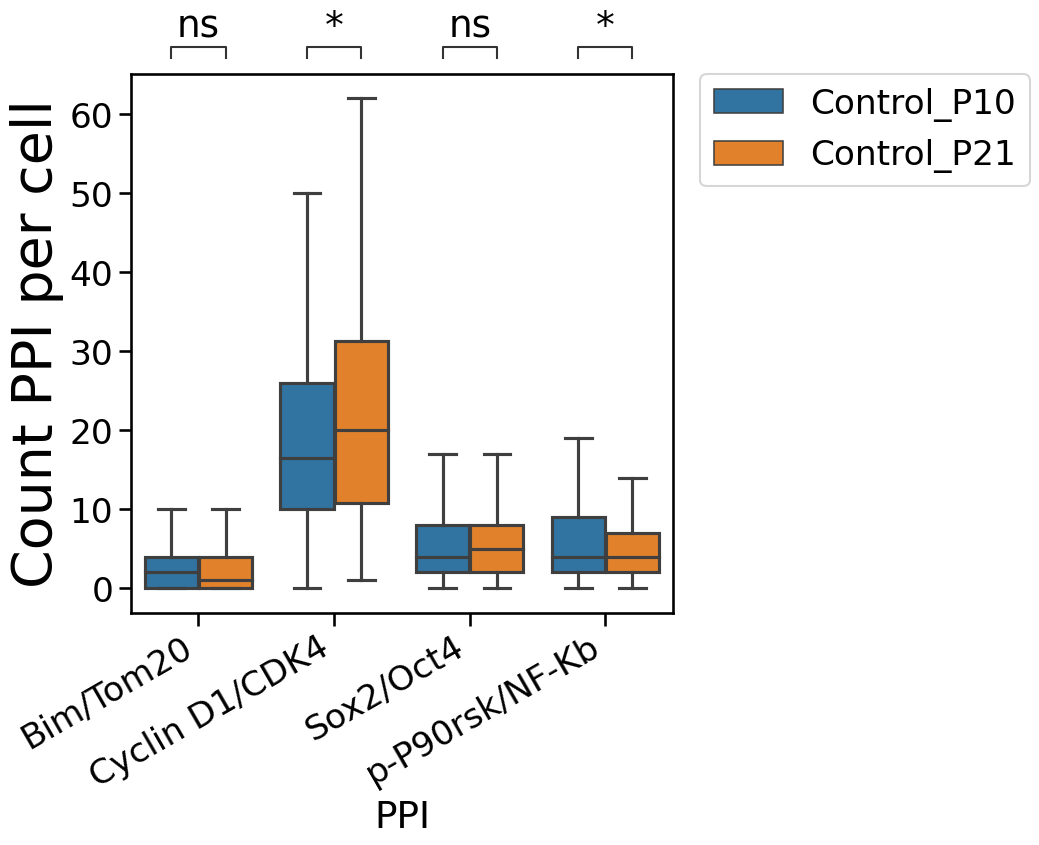

In [37]:
# Boxplot per cell
plotting = {
    "data": df_all[df_all.Condition.isin(['Control_P10', 'Control_P21'])],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

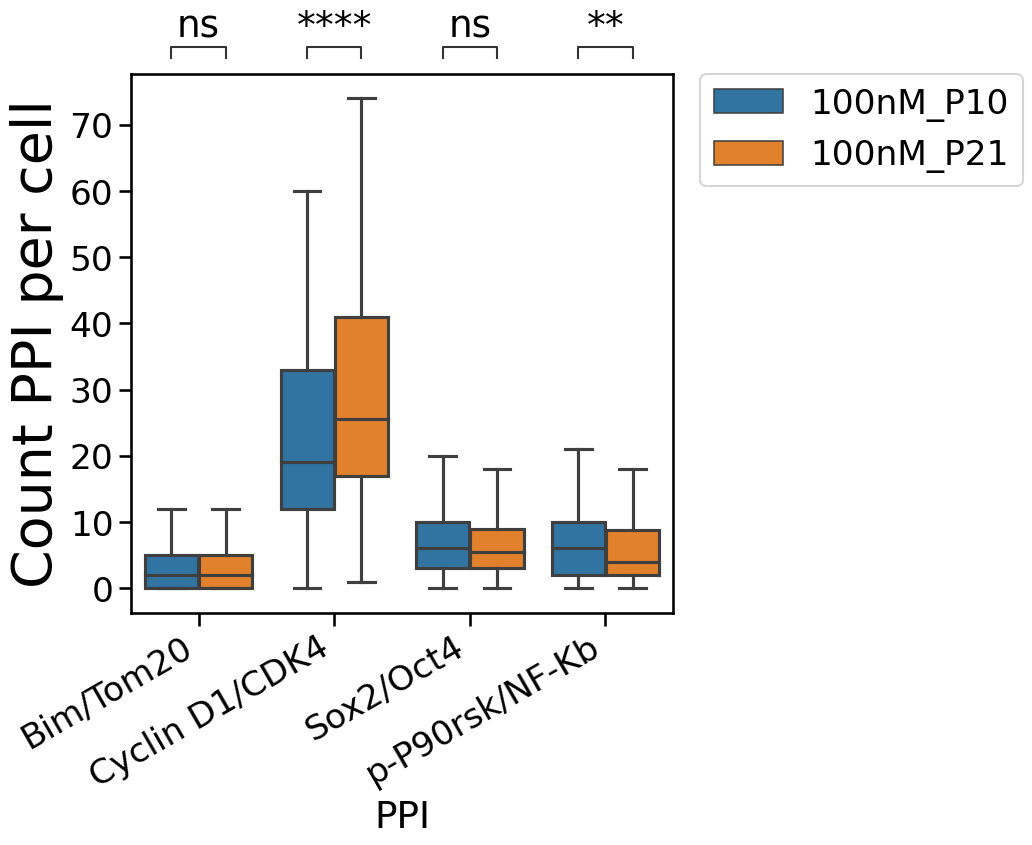

In [35]:
# Boxplot per cell
plotting = {
    "data": df_all[df_all.Condition.isin(['100nM_P10', '100nM_P21'])],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

# Mix plot

In [21]:
import scanpy as sc

In [46]:
# Pivot table to get per cell dataframe
dfCell = df_all.iloc[:, 1:5].pivot_table(index=['FOV', 'Id'], columns=['PPI'], values='Count_cell').reset_index()
dfCell.fillna(0, inplace=True)
dfCell

# Transform into anndata
dfCell_obs = dfCell.iloc[:,:2]
dfCell_int = dfCell.iloc[:,2:]
adata = sc.AnnData(dfCell_int)
adata.var_names = dfCell_int.columns.tolist()
adata.obs = dfCell_obs

# Preprocessing 
sc.pp.log1p(adata)
sc.pp.scale(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)


c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


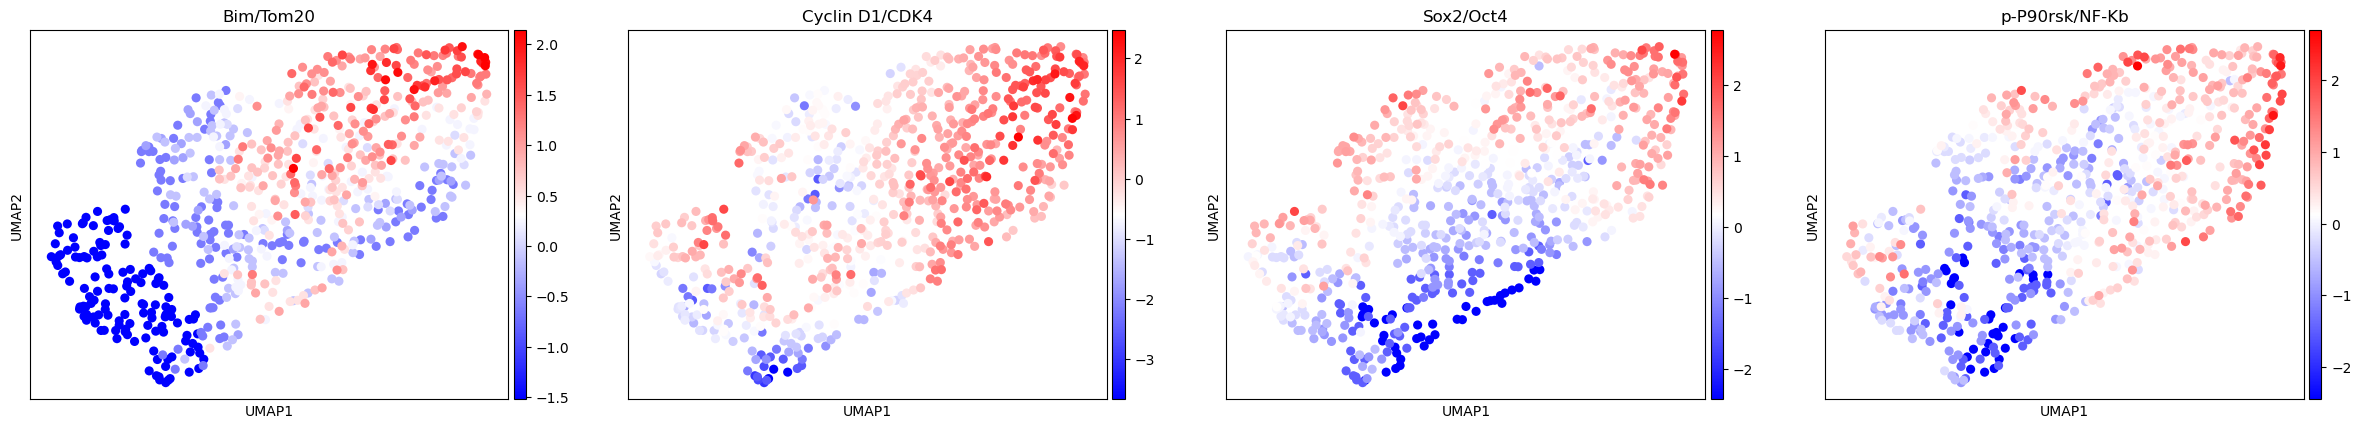

In [52]:
sc.pl.umap(adata, color = adata.var_names, cmap='bwr')